In [165]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm


In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. Работа с данными

In [167]:
train_path = '/content/drive/MyDrive/DLS/vk_test_spam/train_spam.csv'
test_path = '/content/drive/MyDrive/DLS/vk_test_spam/test_spam.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [168]:
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [169]:
X, y = list(train['text'].values), list(train['text_type'].values)

Посмотрим на распределения таргета

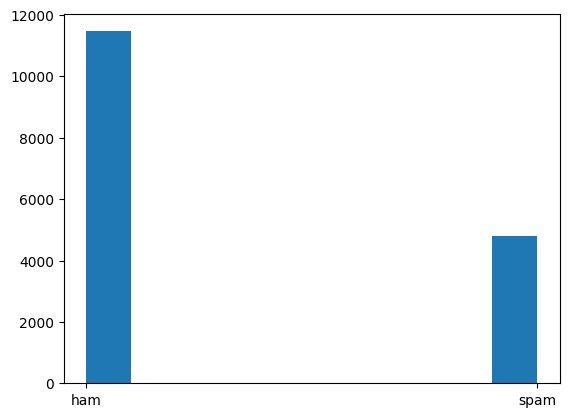

In [170]:
plt.hist(y);

Разобьем данные на обучающие и валидационные. Писем спама меньше - учтем это при разделении данных.

In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y)

y_train = [1 if t == 'spam' else 0 for t in y_train]
y_valid = [1 if t == 'spam' else 0 for t in y_valid]

#### 2. Бейзлайн - TF-IDF + Логистическая регрессия

Сделаем некоторую базовую модель - будем получать эмбеддинги письма на основе TF-IDF(мера важности слов для данного письма в наборе писем), а затем на их основе обучать логистическую регрессию. Оценивать модель будем по метрике roc_auc.   

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [173]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

Обучениe логрега

In [174]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)

pred_train = lg.predict_proba(X_train_tfidf)[:, 1]
pred_valid = lg.predict_proba(X_valid_tfidf)[:, 1]

print('roc auc: train =', roc_auc_score(y_train, pred_train),' valid =', roc_auc_score(y_valid, pred_valid))

roc auc: train = 0.9919886939088118  valid = 0.9774920786254702


Хороший результат для базового решения.

#### 3. Контекстные эмбеддинги на основе нейросетей + Логрег

Одна из главных проблем tf-idf - не учитвание контекста слова. Попробуем применить Word2Veс. Это полносвязная нейросеть учиться предсказывать слова в контексте(skipgram). После обучения матрицы весов содержат в себе эмбеддинги слова как в качестве центрального, так и в качестве контекстного.


In [175]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.tokenize import WordPunctTokenizer

In [176]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Очистим текст и разобьем предложения на слова-токены.

In [177]:
def preprocess(tokenizer, sentences, lemmatizer=None):
    tokens = []
    for sentence in sentences:
        sentence_tokens = []
        for word in tokenizer.tokenize(re.sub('[^a-zA-Z0-9\s]+',"", sentence)):
            if lemmatizer:
                sentence_tokens.append(lemmatizer.lemmatize(word))
            else:
                sentence_tokens.append(word)
        tokens.append(sentence_tokens)

    return tokens

In [178]:
tokenizer = WordPunctTokenizer()
lemmatizer = WordNetLemmatizer()

train_tokens = preprocess(tokenizer, X_train, lemmatizer)
valid_tokens = preprocess(tokenizer, X_valid, lemmatizer)

Обучим word2vec

In [179]:
embeddings_trained = Word2Vec(train_tokens,
                 vector_size=200,
                 min_count=5,
                 window=5).wv

In [180]:
def tokens_to_vec(tokens, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении

        return: векторное представление для запроса
    """
    result_vector = np.zeros((dim, ))
    size = 0
    n = 0
    for word in tokens:
        if word in embeddings:
            result_vector += embeddings[word]
            size += 1
        else:
            n += 1
    if size != 0:
        return result_vector / size
    return result_vector

In [181]:
def get_embeddings(X_tokens, tokenizer, embeddings):
    X_word2vec = []
    for x in X_tokens:
         X_word2vec.append(tokens_to_vec(x, embeddings_trained, tokenizer))
    return X_word2vec

In [182]:
X_train_word2vec = get_embeddings(train_tokens, tokenizer, embeddings_trained)
X_valid_word2vec = get_embeddings(valid_tokens, tokenizer, embeddings_trained)

In [183]:
lg = LogisticRegression(max_iter=1000)
lg.fit(X_train_word2vec, y_train)

pred_train = lg.predict_proba(X_train_word2vec)[:, 1]
pred_valid = lg.predict_proba(X_valid_word2vec)[:, 1]

print('roc auc: train =', roc_auc_score(y_train, pred_train),' valid =', roc_auc_score(y_valid, pred_valid))

roc auc: train = 0.9071199775829161  valid = 0.9068803227478032


Тут мы можем заметить 2 главные проблемы word2vec: ограниченный словарь и необходимость усреднять ембеддинги слов. Первую проблему мы частично могли бы решить - просто взяв другой очень большой корпус текста(и разбивать на n-граммы, как это делается в FastText). Вторая же проблема требует новых архитектурных решений.

#### 4. Дообучение Bert

Bert(видоизмененный енкодер трансоформера) содержит в сeбе механизм внимания, который сам определяет важность данного конекста для ембеддинга слова.

Введем токен предложения из Берта + обучим на нем полносвязный слой

In [184]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModel
import transformers

import nltk
import re
import string
import copy
import gc

In [185]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Напишем свой обёртку для удобной работы с данными

In [186]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
        }

Напишем кастомный класс для дообучения Berta c замороженными весами

In [187]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.backbone = model
        self.output_features = self.backbone.encoder.layer[1].output.dense.out_features
        self.linear1 = nn.Linear(self.output_features, self.output_features // 2)
        self.non_linear = nn.Tanh()
        self.linear2 = nn.Linear(self.output_features // 2, num_labels)

    def forward(self, inputs, attention):
        outputs = self.backbone(inputs , attention)
        pooler_output = outputs['pooler_output']
        attention_output = outputs['attentions']
        outputs = self.linear1(pooler_output)
        outputs = self.linear2(self.non_linear(outputs))
        return (outputs, attention_output)

Код для заморозки весов модели

In [188]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

Цикл дообучения верхних слоёв:

In [189]:
def train_transformer(transformer_model, train_loader, eval_loader, num_epochs=3, freeze_backbone=True):
    model = copy.deepcopy(transformer_model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    if freeze_backbone:
        model = freeze_backbone_function(model)

    loss_epochs = {'eval' : [], 'train' : []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for (i, batch) in enumerate(train_loader):
            optimizer.zero_grad()
            logit = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0]
            loss = criterion(logit, batch['label'].long().to(device))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()


        if (epoch % 2) == 0:
            model.eval()
            eval_loss = 0
            with torch.no_grad():
                for (i, batch) in enumerate(eval_loader):
                    logit = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0]
                    loss = criterion(logit, batch['label'].long().to(device))
                    eval_loss += loss.item()

            print("epoch :", epoch, "loss train:", train_loss/len(train_loader), "eval loss:", eval_loss/len(eval_loader))
            loss_epochs['eval'].append(eval_loss/len(eval_loader))
            loss_epochs['train'].append(train_loss/len(train_loader))
        torch.cuda.empty_cache()
        gc.collect()

    return (model, loss_epochs)

In [190]:
bert = TransformerClassificationModel(AutoModel.from_pretrained("bert-base-uncased", output_attentions=True), 2).to(device)
tokenizer_bert = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

In [191]:
train_dataset = MyDataset(X_train, y_train, tokenizer_bert)
valid_dataset = MyDataset(X_valid, y_valid, tokenizer_bert)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, drop_last=True)

In [192]:
num_epochs = 7

bert_freeze, losses = train_transformer(bert, train_loader, val_loader, num_epochs, freeze_backbone=True)

  0%|          | 0/7 [00:00<?, ?it/s]

epoch : 0 loss train: 0.5034965969036135 eval loss: 0.42604424569167587
epoch : 2 loss train: 0.32125505821758443 eval loss: 0.2766580900275393
epoch : 4 loss train: 0.29040943115447343 eval loss: 0.24572521644203285
epoch : 6 loss train: 0.2706663710264008 eval loss: 0.24782796017825603


In [193]:
def calc_loss_graph(losses):
    plt.plot(np.arange(0, len(losses['eval'])*2, 2), losses['eval'], label='eval', c='r')
    plt.plot(np.arange(0, len(losses['eval'])*2, 2), losses['train'], label='train', c='g')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title('Bert')
    plt.legend()
    plt.show()

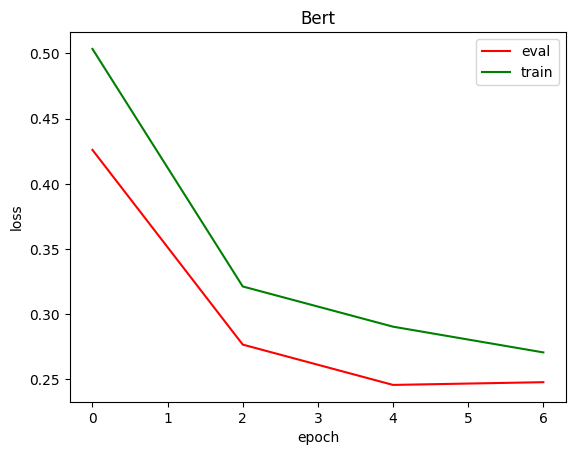

In [194]:
calc_loss_graph(losses)

In [198]:
labels = []
preds = []
for batch in tqdm(train_loader):
    labels.extend(batch['label'].cpu().numpy())
    preds.extend(bert_freeze(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0][:, 1].detach().cpu().numpy())

p = 1/(1 + np.exp(-np.array(preds)))
print('roc_auc train : ' , roc_auc_score(labels, p))

  0%|          | 0/356 [00:00<?, ?it/s]

roc_auc train :  0.9574391850979911


In [199]:
labels = []
preds = []
for batch in tqdm(val_loader):
    labels.extend(batch['label'].cpu().numpy())
    preds.extend(bert_freeze(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0][:, 1].detach().cpu().numpy())

p = 1/(1 + np.exp(-np.array(preds)))
print('roc_auc train : ' , roc_auc_score(labels, p))

  0%|          | 0/152 [00:00<?, ?it/s]

roc_auc train :  0.9553556132560709


#### 5. Делаем финальный скор

Возьмем нашу базовую модель с tf-idf и logreg. Хорошие показания этого решения можно объяснить тем,что tf-idf - отлично вычленяет ключевые слова для документа. Это важно при работе со спамом, т.к. даже человек часто определяет тип сообщения по некотрым наиболее характерным словам(ключам).

In [226]:
X_test = list(test['text'].values)
tfidf_vectorizer = TfidfVectorizer()

X_tfidf = tfidf_vectorizer.fit_transform(X)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [227]:
lg = LogisticRegression()
lg.fit(X_tfidf, y)

pred_test = lg.predict_proba(X_test_tfidf)[:, 1]

In [229]:
result = pd.DataFrame({'text' : X_test, 'score' : pred_test})
result.to_csv("/content/drive/MyDrive/DLS/vk_test_spam/test_scored.csv")

#### 6. Что можно изменить/добавить?



1.   Больше внимания уделить первичной обработке сообщения: убрать служебные знаки, привести к одному регистру.
2.   Сделать подбор гиперпараметров для модели классификации. Попробовать другие модели, например, градиентный бустинг.
3.   RNN, LSTM
4.   Изменить архитектуру полносвязного слоя для Берта. Взять более тяжёлую модель или попробовать разморозить несколько верхних слоев.  

